In [2]:
import scipy as sp
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import time
import h5py as h5
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

%matplotlib inline

\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) =\mathcal{L}(r, \alpha, R) = \frac{4\pi}{(2\pi)^3}\int_0^\infty \frac{q\sin{qr}}{r}e^{-|qR|^\alpha}dq
\end{equation}

\begin{equation}
\int_a^b f(x)dx = \frac{b-a}{2}\int_{-1}^1 f\bigg(\frac{b-a}{2}z+\frac{a+b}{2}\bigg)dz = \sum_i w_i f(x_i)
\end{equation}

\begin{equation}
    \int_{z}^{z+\Delta z} f(x)dx = \frac{\Delta z}{2}\int_{-1}^1 f\bigg(\frac{\Delta z}{2}\xi+\frac{2z+\Delta z}{2}\bigg)d\xi = \sum_i w_i f(\xi_i)
\end{equation}

In [3]:
mod = SourceModule("""
__device__  float f(const float& x){
    return x*x;
}

__device__ void small(float& value, float& error, float a, float b, int n1, int n2, float * nodes, float * weights, int * gauss, int * others){
        float A = 0.5*(b-a);
        float B = 0.5*(b+a);
        float s = 0.0;
        float g7 = 0.0;
        int i = 0;
        for(i=0;i<n1;i++){
           g7 += weights[gauss[i]]*f(A*nodes[gauss[i]]+B); 
        }
        for(i=0;i<n2;i++){
            s += weights[others[i]]*f(A*nodes[others[i]]+B);
        }
        error = powf(200*fabsf(s-g7), 1.5);
        value = (s+g7)*A;
}

__global__ void integrate(float *res, double *steps, float * eps0, int *n1, int *n2, float *a, float *b, float * nodes, float * weights, int * gauss, int * others){
    double dz = 1e-5;
    float s  = 0.0;
    float z  = *a;
    float ss = 0.0;
    float error = 0.0;
    int j=0;
    // z ... z+dz
    int i=0;
    while(z<*b){
        small(ss, error, z, z+dz, *n1, *n2, nodes, weights, gauss, others);
        j = 0;
        while (*eps0<error){
            dz /= 2;
            small(ss, error, z, z+dz, *n1, *n2, nodes, weights, gauss, others);
            if (j>10) break;
            j += 1;
        }
        if (dz<1e-5) dz = 1e-5;
        if (*eps0>error){
            dz *= 2;
        }
        s += ss;
        z += dz;
        //steps[i] = dz;
        if (i>100) break;
        i +=1;
    }
    *res = s;
}

""")

In [4]:
cuda_int = mod.get_function("integrate")

In [5]:
res = np.array([0.0], dtype=np.float32)
N = np.int32(8)
a = np.float32(0.0)
b = np.float32(5.0)

In [6]:
nodes = np.array([
    -0.991455371120813, 0.991455371120813,
    -0.949107912342759, 0.949107912342759,
    -0.864864423359769, 0.864864423359769,
    -0.741531185599394, 0.741531185599394,
    -0.586087235467691, 0.586087235467691,
    -0.405845151377397, 0.405845151377397,
    -0.207784955007898, 0.207784955007898,
    0.0
], np.float32)

weights = np.array([
    0.022935322010529, 0.022935322010529,
    0.063092092629979, 0.063092092629979,
    0.104790010322250, 0.104790010322250,
    0.140653259715525, 0.140653259715525,
    0.169004726639267, 0.169004726639267,
    0.190350578064785, 0.190350578064785,
    0.204432940075298, 0.204432940075298,
    0.209482141084728
], np.float32)

gauss_nodes = np.array([
    2, 3,
    6, 7,
    10,11,
    14
], np.int32)

others = np.array([i for i in range(len(weights))], np.int32)

others = np.delete(others, gauss_nodes)

N1 = np.int32(len(gauss_nodes))
N2 = np.int32(len(others))

In [7]:
others

array([ 0,  1,  4,  5,  8,  9, 12, 13])

In [6]:
steps = np.array([1]*500, np.double)
error0 = np.float32(1)

In [7]:
cuda_int(cuda.Out(res), cuda.Out(steps),cuda.In(error0), cuda.In(N1), cuda.In(N2), cuda.In(a), 
          cuda.In(b), cuda.In(nodes), cuda.In(weights), cuda.In(gauss_nodes), cuda.In(others),
          block=(1,1,1))

In [8]:
res

array([ 0.25492838], dtype=float32)

In [9]:
steps

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [65]:
integrate.quad(lambda x: x*np.sin(x*20)*np.exp(-np.power(x, 0.7)/2), 0, 5, limit=1000)

(-0.04587849643337012, 5.93953005393393e-09)

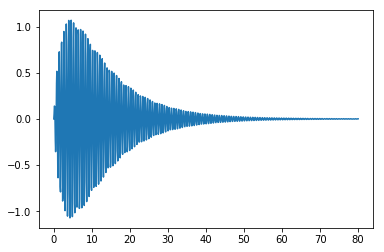

In [67]:
x = np.linspace(0, 80, 1000)
y = x*np.sin(x*10)*np.exp(-np.power(x, 0.7)/2)
plt.plot(x,y)

In [7]:
nodes   = np.array([-0.1834346424956498, 0.1834346424956498,-0.5255324099163290,0.5255324099163290,-0.7966664774136267,0.7966664774136267,-0.9602898564975363,0.9602898564975363], np.float32)
weights = np.array([0.3626837833783620,0.3626837833783620,0.3137066458778873,0.3137066458778873,0.2223810344533745,0.2223810344533745,0.1012285362903763,0.1012285362903763], np.float32)
N = np.int32(len(weights))

In [12]:
def f(x):
    return x*x

def small(a,b,weights, nodes):
    A = 0.5*(b-a)
    B = 0.5*(a+b)
    s = 0.0
    for i in range(len(weights)):
        s += weights[i]*f(A*nodes[i]+B)
    return A*s

def adaptive(a,b,weights, nodes, gauss_nodes):
    z = a
    dz = 0.1
    s = 0.0
    while z<b:
        s += small(z, z+dz, weights, nodes)
    return s

In [13]:
adaptive(a,b,weights, nodes, gauss_nodes)

KeyboardInterrupt: 

In [ ]:
small(a,b,weights, nodes)